# Agentic RAG tutorial
Note: Code mostly copied from LangChain's tutorial https://python.langchain.com/docs/tutorials/qa_chat_history/

This tutorial will show you how to implement a simple Agentic RAG pipeline with message history.

# Setup

In [ ]:
!pip install -qU langchain
!pip install -qU langchain-google-genai
!pip install -qU langchain-huggingface
!pip install -qU langchain-chroma
!pip install -qU langchain-community
!pip install -qU langgraph
!pip install -qU pypdf
!pip install -q fixthaipdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.4/415.4 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.4 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.16 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 858.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
import os
from google.colab import userdata

os.environ["GOOGLE_API_KEY"] = userdata.get('gemini_api_key')

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-001")

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [ ]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings)

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from fixthaipdf import clean

file_path = (
    "/content/CR99_2024Th.pdf"
)
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

pages[0]

Document(metadata={'producer': 'Canva', 'creator': 'Canva', 'creationdate': '2024-08-26T08:56:17+00:00', 'title': 'CR90', 'moddate': '2024-08-28T16:46:33+07:00', 'keywords': 'DAFkkNfTFw0,BAEQi0sFysc', 'author': 'Busaba Cheunjit', 'source': '/content/CR99_2024Th.pdf', 'total_pages': 37, 'page': 0, 'page_label': '1'}, page_content='จท 99\n \n คู\x00มือนิสิตเกี่ยวกับงานทะเบียนนิสิต\nป \x00 ก า ร ศ ึ ก ษ า  2567')

In [ ]:
for page in pages:
  page.page_content = clean(page.page_content)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(pages)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 92 sub-documents.


In [ ]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['f935fbc1-1e54-4aa4-839a-ec3ee1a1a05b', '0db6d496-b210-4fc2-a351-f18d7bdd0293', 'e75f458b-ad9c-43eb-9435-dd44c5f56134']


# Code

## Agentic RAG

Conversational experiences can be naturally represented using a sequence of [messages](https://python.langchain.com/docs/concepts/messages/). In addition to messages from the user and assistant, retrieved documents and other artifacts can be incorporated into a message sequence via [tool messages](https://python.langchain.com/docs/concepts/messages/#toolmessage). This motivates us to represent the state of our RAG application using a sequence of messages. Specifically, we will have

1. User input as a `HumanMessage`;
2. Vector store query as an `AIMessage` with tool calls;
3. Retrieved documents as a `ToolMessage`;
4. Final response as a `AIMessage`.

This model for state is so versatile that LangGraph offers a built-in version for convenience:

In [ ]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

Leveraging [tool-calling](https://python.langchain.com/docs/concepts/tool_calling/) to interact with a retrieval step has another benefit, which is that the query for the retrieval is generated by our model. This is especially important in a conversational setting, where user queries may require contextualization based on the chat history. For instance, consider the following exchange:

> Human: "What is Task Decomposition?"
>
> AI: "Task decomposition involves breaking down complex tasks into smaller and simpler steps to make them more manageable for an agent or model."
>
> Human: "What are common ways of doing it?"

In this scenario, a model could generate a query such as `"common approaches to task decomposition"`. Tool-calling facilitates this naturally. This allows a model to rewrite user queries into more effective search queries. It also provides support for direct responses that do not involve a retrieval step (e.g., in response to a generic greeting from the user).

Let's turn our retrieval step into a [tool](https://python.langchain.com/docs/concepts/tools):

In [ ]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query from a vector database containing information on student's handbook."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

Our graph will consist of three nodes:

1. A node that fields the user input, either generating a query for the retriever or responding directly;
2. A node for the retriever tool that executes the retrieval step;
3. A node that generates the final response using the retrieved context.

We build them below. Note that we leverage another pre-built LangGraph component, [ToolNode](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.ToolNode), that executes the tool and adds the result as a `ToolMessage` to the state.

In [ ]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
# The ToolNode is roughly analogous to:

# tools_by_name = {tool.name: tool for tool in tools}
# def tool_node(state: dict):
#     result = []
#     for tool_call in state["messages"][-1].tool_calls:
#         tool = tools_by_name[tool_call["name"]]
#         observation = tool.invoke(tool_call["args"])
#         result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
#     return {"messages": result}

tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

Finally, we compile our application into a single `graph` object. In this case, we are just connecting the steps into a sequence. We also allow the first `query_or_respond` step to "short-circuit" and respond directly to the user if it does not generate a tool call. This allows our application to support conversational experiences-- e.g., responding to generic greetings that may not require a retrieval step

In [ ]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

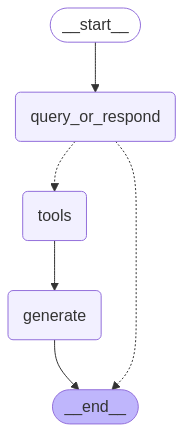

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Stateful management of chat history

To manage multiple conversational turns and threads, all we have to do is specify a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/) when compiling our application. Because the nodes in our graph are appending messages to the state, we will retain a consistent chat history across invocations.

LangGraph comes with a simple in-memory checkpointer, which we use below. See its [documentation](https://langchain-ai.github.io/langgraph/concepts/persistence/) for more detail, including how to use different persistence backends (e.g., SQLite or Postgres).

For a detailed walkthrough of how to manage message history, head to the [How to add message history (memory)](/docs/how_to/message_history) guide.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

We can now invoke similar to before:

In [ ]:
input_message = "บัตรนิสิตหายต้องทำยังไง"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

บัตรนิสิตหายต้องทำยังไง
================================== Ai Message ==================================

ขออภัยค่ะ ฉันยังไม่มีข้อมูลเกี่ยวกับวิธีการดำเนินการเมื่อบัตรนิสิตหาย หากต้องการทราบข้อมูลนี้ สามารถลองค้นหาในคู่มือนิสิตนักศึกษาได้ค่ะ


In [ ]:
input_message = "5 สาขาที่ว่านี่อะไรบ้าง"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

5 สาขาที่ว่านี่อะไรบ้าง
================================== Ai Message ==================================

ขออภัยค่ะ ฉันไม่เข้าใจว่าคุณกำลังหมายถึงอะไร คุณช่วยระบุคำถามของคุณอีกครั้งได้ไหม
